In [ ]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 先卸载（如果需要）
from google.colab import drive
drive.flush_and_unmount()

# 然后重新挂载
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import multiprocessing
print("CPU 内核数:", multiprocessing.cpu_count())

CPU 内核数: 2


In [ ]:
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/YX_homework"
!ln -Ts "$folder" /content/news_data 2> /dev/null

if '/content/news_data' not in sys.path:
  sys.path.insert(0, '/content/news_data')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:
!ls /content/news_data/

df_comments_processed.tsv  df_posts_100k.tsv   glove.6B.100d.txt
df_comments_sample.tsv	   df_sample_100k.tsv  hw2


## 1. Install packages and Load data

In [ ]:
# Install packages
import subprocess

packages = [
    "gdown",
    "textblob",
    "NRCLex==3.0.0",
    "autocorrect==1.1.0",
    "contractions",
    "unidecode",
    "emoji",
    "nltk",
    "scikit-learn",
    "tensorflow"
]

subprocess.run("pip install --upgrade pip setuptools -q", shell=True)

for package in packages:
    try:
        print(f"Installing {package}...")
        subprocess.run(f"pip install -q {package}", shell=True, check=True)
        print(f"{package} installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package}: {e}")

Installing gdown...
gdown installed successfully.
Installing textblob...
textblob installed successfully.
Installing NRCLex==3.0.0...
NRCLex==3.0.0 installed successfully.
Installing autocorrect==1.1.0...
autocorrect==1.1.0 installed successfully.
Installing contractions...
contractions installed successfully.
Installing unidecode...
unidecode installed successfully.
Installing emoji...
emoji installed successfully.
Installing nltk...
nltk installed successfully.
Installing scikit-learn...
scikit-learn installed successfully.
Installing tensorflow...
tensorflow installed successfully.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd

# Load train, validation, and test data (TSV files)
df_train = pd.read_csv('/content/news_data/multimodal_train.tsv', sep='\t', on_bad_lines='skip')
df_val   = pd.read_csv('/content/news_data/multimodal_validate.tsv', sep='\t', on_bad_lines='skip')
df_test  = pd.read_csv('/content/news_data/multimodal_test_public.tsv', sep='\t', on_bad_lines='skip')

df_posts = pd.concat([df_train, df_val, df_test], ignore_index=True)
print("Total posts loaded:", len(df_posts))

Total posts loaded: 682661


In [ ]:
import pandas as pd

# Load train, validation, and test data (TSV files)
# df_train = pd.read_csv('/content/news_data/multimodal_train_80k.tsv', sep='\t', on_bad_lines='skip')
# df_val   = pd.read_csv('/content/news_data/multimodal_eval_20k.tsv', sep='\t', on_bad_lines='skip')
# df_test  = pd.read_csv('/content/news_data/multimodal_test_public.tsv', sep='\t', on_bad_lines='skip')

# df_posts = pd.concat([df_train, df_val], ignore_index=True)
# print("Total posts loaded:", len(df_posts))

In [ ]:
# Load comments data
df_comments = pd.read_csv('/content/news_data/all_comment.tsv', sep='\t', on_bad_lines='skip')
print("Total comments loaded:", len(df_comments))
# Peek at columns
# print("Post columns:", df_posts.columns.tolist())
print("Comment columns:", df_comments.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: '/content/news_data/all_comment.tsv'

In [ ]:
df_posts['2_way_label'].mean()

np.float64(0.5)

## 2. Data pre-processing

In [ ]:
# Remove posts with missing or empty titles
df_posts = df_posts.dropna(subset=['clean_title'])
print(len(df_posts))
df_posts = df_posts[df_posts['clean_title'].str.strip().astype(bool)]
print(len(df_posts))

df_posts = df_posts.dropna(subset=['2_way_label'])
print(len(df_posts))

df_posts['2_way_label'] = df_posts['2_way_label'].astype(int)
print(len(df_posts))

100000
100000
100000
100000


In [ ]:

# post_ids_with_comments = set(df_comments['submission_id'].unique())
# df_posts = df_posts[df_posts['id'].isin(post_ids_with_comments)]
print(len(df_posts))
# Drop duplicate titles if any (to remove duplicate news)
# df_posts = df_posts.drop_duplicates(subset=['clean_title'])

print("Filtered posts count:", len(df_posts))
print("Fake news count:", sum(df_posts['2_way_label'] == 1))
print("Real news count:", sum(df_posts['2_way_label'] == 0))

100000
Filtered posts count: 100000
Fake news count: 50000
Real news count: 50000


## 3. Text pre-processing

In [ ]:
# Remove HTML tags and URLs.
# Normalize accented characters (e.g., “café” -> “cafe”).
# Expand contractions (e.g., "can't" -> "cannot").
# Convert emojis to text (e.g., 😢 -> ":crying_face:" -> "crying face").
# Remove special characters (keeping only letters, numbers, whitespace, and ! and ? as they may carry sentiment).
# Fix spelling of words (using autocorrect).
# Remove stopwords (common words like “the”, “and”).
# Trim extra whitespace.

In [ ]:
import re
import string
from autocorrect import Speller
from unidecode import unidecode
import emoji
import contractions
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

spell = Speller(lang='en')
stop_words = set(stopwords.words('english'))

punct_to_keep = "!?";

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = contractions.fix(text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = unidecode(text)
    text = text.replace(":", " ")
    text = text.replace("_", " ")
    text = re.sub(f"[^{re.escape(string.ascii_letters + string.digits + string.whitespace + punct_to_keep)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    corrected_words = []
    for word in text.split():
        if word not in punct_to_keep:
            corrected = spell(word)
        else:
            corrected = word
        corrected_words.append(corrected)
    text = ' '.join(corrected_words)
    text = ' '.join(w for w in text.split() if w not in stop_words)
    text = text.strip()
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Test cases
test_cases = [
    "Great!!! This isn't a <b>drill</b> 😱. https://example.com now.",
    "great !!! drill 😱",
    "Happy 😊 day",
    "Sad 😢 tears",
    "Café 😍 time"  # Test with accented characters
]

for test in test_cases:
    print("Original:", test)
    print("Cleaned: ", clean_text(test))
    print()

Original: Great!!! This isn't a <b>drill</b> 😱. https://example.com now.
Cleaned:  great!!! drill face screaming fear

Original: great !!! drill 😱
Cleaned:  great !!! drill face screaming fear

Original: Happy 😊 day
Cleaned:  happy smiling face smiling eyes day

Original: Sad 😢 tears
Cleaned:  sad crying face tears

Original: Café 😍 time
Cleaned:  cafe smiling face heart eyes time



## 4. Sentiment Analysis of Titles

In [ ]:
from textblob import TextBlob
from tqdm import tqdm

# tqdm.pandas()
# # df_posts['title_cleaned'] = df_posts['clean_title'].apply(clean_text)
# df_posts['title_cleaned'] = df_posts['clean_title'].progress_apply(clean_text)

# df_posts['sentiment_score'] = df_posts['title_cleaned'].apply(lambda txt: TextBlob(txt).sentiment.polarity)

# print(df_posts[['clean_title', 'title_cleaned', 'sentiment_score']].head(5))

# the result ranges from -1.0 (very negative) to +1.0 (very positive), with 0 being neutral.

In [ ]:
df_posts['sentiment_score'] = df_posts['title_cleaned'].apply(lambda txt: TextBlob(txt).sentiment.polarity)

In [ ]:
print(df_posts[['clean_title', 'title_cleaned', 'sentiment_score']].head(5))

                                         clean_title  \
0      irs spent to make parody of trumps apprentice   
1                    this cloud casting a big shadow   
2  my poor positioning and the fact that the sky ...   
3                    poop hot seller at disney world   
4  gov chris christie at the stroke of midnight f...   

                                       title_cleaned  sentiment_score  
0            irs spent make parody trumps apprentice        -0.100000  
1                           cloud casting big shadow         0.000000  
2  poor positioning fact sky included reason see ...        -0.400000  
3                       poop hot seller disney world         0.250000  
4  gov chris christie stroke midnight friday orde...        -0.075758  


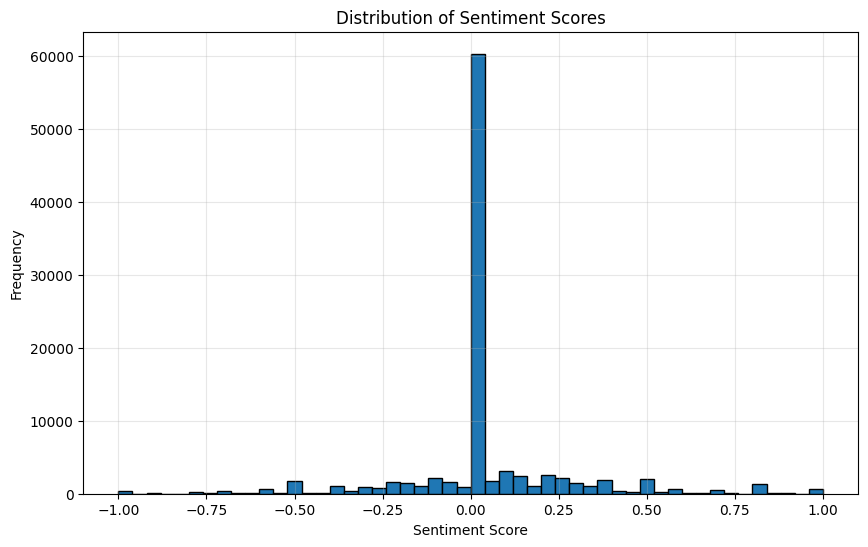

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_posts['sentiment_score'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df_posts.shape

(100000, 18)

In [ ]:
# Define the target directory
output_dir = '/content/gdrive/MyDrive/fakenews_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

# Save DataFrame to TSV
output_path = os.path.join(output_dir, 'df_posts_100k.tsv')
df_posts.to_csv(output_path, sep='\t', index=False)
print(f"DataFrame saved to {output_path}")

print("File exists:", os.path.exists(output_path))

Directory already exists: /content/gdrive/MyDrive/fakenews_data
DataFrame saved to /content/gdrive/MyDrive/fakenews_data/df_posts_100k.tsv
File exists: True


In [ ]:
df_sample = pd.read_csv('/content/news_data/df_posts_100k.tsv', sep='\t', on_bad_lines='skip')

In [ ]:
df_sample = df_posts.sample(n=100000, random_state=42)

In [ ]:
df_sample

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score
0,NaN,irs spent to make parody of trumps apprentice,1.378496e+09,washingtontimes.com,True,1lvef5,https://external-preview.redd.it/ShAIXfDYep86x...,NaN,7.0,167,nottheonion,"IRS spent $10,000 to make parody of Trump's 'A...",0.88,1,0,0,irs spent make parody trumps apprentice,-0.100000
1,MyPilotsRomance,this cloud casting a big shadow,1.570136e+09,i.redd.it,True,dcx1bq,https://preview.redd.it/5udgxv9p0dq31.jpg?widt...,NaN,4.0,32,photoshopbattles,PsBattle: this cloud casting a big shadow,0.85,1,0,0,cloud casting big shadow,0.000000
2,howtokillyourdreams,my poor positioning and the fact that the sky ...,1.554055e+09,i.redd.it,True,b7qn6m,https://preview.redd.it/0xmqk4xyuhp21.jpg?widt...,NaN,3.0,15,mildlyinteresting,My poor positioning (and the fact that the sky...,0.84,1,0,0,poor positioning fact sky included reason see ...,-0.400000
3,Nekronicle,poop hot seller at disney world,1.435174e+09,lasvegasnow.com,True,3azj61,https://external-preview.redd.it/K2lUz2pypkqVR...,NaN,2.0,13,nottheonion,Poop: Hot seller at Disney World,0.93,1,0,0,poop hot seller disney world,0.250000
4,NaN,gov chris christie at the stroke of midnight f...,1.498888e+09,nj.com,True,6klf2u,https://external-preview.redd.it/k3c-gV-l7qMVo...,NaN,1.0,3,usanews,Gov. Chris Christie at the stroke of midnight ...,0.72,1,0,0,gov chris christie stroke midnight friday orde...,-0.075758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,all-top-today_SS,the strength of a fire hydrant and a fire hydr...,1.551287e+09,i.redd.it,True,avfmop,https://preview.redd.it/lquqhf3j8yi21.jpg?widt...,NaN,18.0,30,subredditsimulator,The strength of a fire hydrant and a fire hydr...,0.85,0,2,3,strength fire hydrant fire hydrant km run ever...,-0.071429
99996,FloridaMan_SS,people wind up in the face with ramen noodles,1.507791e+09,dailymail.co.uk,True,75vbcc,https://external-preview.redd.it/NVuXPi8HNdrE9...,NaN,23.0,17,subredditsimulator,3 people wind up in the face with Ramen noodles,0.99,0,2,3,people wind face ramen noodles,0.000000
99997,BearcatChemist,redheaded girl in attack mode,1.418050e+09,i.imgur.com,True,2ondsg,https://external-preview.redd.it/H3UqCq9VHC3jh...,NaN,642.0,6252,photoshopbattles,PsBattle: Red-headed girl in attack mode.,0.87,1,0,0,redheaded girl attack mode,0.000000
99998,BleuTomateio,glitter coming down from the new years party i...,1.552945e+09,i.imgur.com,True,b2og7i,https://external-preview.redd.it/b2xLhrJrl6Kbz...,NaN,0.0,19,misleadingthumbnails,Glitter coming down from the New Years party i...,0.84,0,2,2,glitter coming new years party heaven,0.136364


## 5. Emotion Analysis of Comments

In [ ]:
# Novelty group: emotions of fear, disgust, and surprise (we also include anger in this group, as it was presumably intended​).
# Expectation group: emotions of anticipation, sadness, joy, and trust​
# Neutral group: applies if the comment’s emotions are balanced (i.e., the summed scores for novelty vs. expectation emotions are equal)​

In [ ]:
from nrclex import NRCLex

# Classify a single comment into Novelty / Expectation / Neutral
def classify_comment_emotion(comment_text: str) -> str:
    text = clean_text(comment_text)
    if not text:
        return "neutral"
    emotion = NRCLex(text)
    scores = emotion.raw_emotion_scores

    novelty_score = scores.get('anger', 0) + scores.get('fear', 0) + scores.get('disgust', 0) + scores.get('surprise', 0)
    expect_score = scores.get('anticipation', 0) + scores.get('sadness', 0) + scores.get('joy', 0) + scores.get('trust', 0)

    if novelty_score > expect_score:
        return "novelty"
    elif expect_score > novelty_score:
        return "expectation"
    else:
        return "neutral"

In [ ]:
df_comments_sample = df_comments[df_comments['submission_id'].isin(df_sample['id'])].copy()
print("Sample Comments for filtered posts:", len(df_comments_sample))

Sample Comments for filtered posts: 1627529


In [ ]:
df_test = df_comments_sample.sample(n=100000, random_state=42)

In [ ]:
import re
import string
from unidecode import unidecode
import emoji
import contractions
import pandas as pd
from joblib import Parallel, delayed
import time

punct_to_keep = "!?"
html_pattern = re.compile(r'<.*?>')
url_pattern = re.compile(r'http\S+|www\.\S+')
special_char_pattern = re.compile(f"[^{re.escape(string.ascii_letters + string.digits + string.whitespace + punct_to_keep)}]")
whitespace_pattern = re.compile(r'\s+')


def clean_text_comment(text) -> str:
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    text = text.lower()
    text = html_pattern.sub(' ', text)
    text = url_pattern.sub(' ', text)
    text = contractions.fix(text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = unidecode(text)
    text = text.replace(":", " ").replace("_", " ")
    text = special_char_pattern.sub(' ', text)
    text = whitespace_pattern.sub(' ', text).strip()
    return text

def parallel_clean(df, column_name):
    return Parallel(n_jobs=-1)(delayed(clean_text_comment)(text) for text in df[column_name])

test = "I'm from KY, and just  😍 happy to see a nice stor"
print("Original:", test)
print("Cleaned: ", clean_text_comment(test))

Original: I'm from KY, and just  😍 happy to see a nice stor
Cleaned:  i am from ky and just smiling face with heart eyes happy to see a nice stor


In [ ]:
start_time = time.time()

df_comments_sample['body'] = df_comments_sample['body'].astype(str).fillna('')

df_comments_sample['comment'] = parallel_clean(df_comments_sample, 'body')

end_time = time.time()
print(f"Cleaning took {end_time - start_time:.2f} seconds")

print(df_comments_sample.head())

Cleaning took 48.90 seconds
      Unnamed: 0       id          author  \
24401      25446  f3oi6l9    EPICJAYSON12   
24402      25447  f3vd0i0        cpcallen   
24534      25579  f3etn1u     KingOrion77   
24535      25580  f3ess08        Pototsky   
24536      25581  f3f5lmk  davidforslunds   

                                                    body isTopLevel  \
24401                       This is a very wholesome gif       True   
24402  I love the fact that the title describes both ...       True   
24534                Who use the term “Stroking my dog”?       True   
24535  It is in us and around us. This whole place is...       True   
24536                              *Uzumaki intensifies*       True   

       parent_id submission_id   ups  \
24401  t3_dhiuq5        dhiuq5   1.0   
24402  t3_dhiuq5        dhiuq5   1.0   
24534  t3_dgs5id        dgs5id  55.0   
24535  t3_dgs5id        dgs5id  15.0   
24536  t3_dgs5id        dgs5id   9.0   

                                 

In [ ]:
df_comments_sample

,Unnamed: 0,id,author,body,isTopLevel,parent_id,submission_id,ups,comment
24401,25446,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif
24402,25447,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...
24534,25579,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?
24535,25580,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...
24536,25581,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies
...,...,...,...,...,...,...,...,...,...
10697507,10601559,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0,this type of impact people choose to have on e...
10697508,10601560,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0,i am bawlin ovah heah!
10697509,10601561,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0,does not it look a bit fake? i mean there was ...
10697510,10601562,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0,i do not think anybody could fake his reaction...


In [ ]:

df_comments_sample = df_comments_sample.drop(columns=['Unnamed: 0'], errors='ignore')


df_comments_sample = df_comments_sample.reset_index(drop=True)

In [ ]:
df_comments_sample

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies
...,...,...,...,...,...,...,...,...
1627524,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0,this type of impact people choose to have on e...
1627525,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0,i am bawlin ovah heah!
1627526,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0,does not it look a bit fake? i mean there was ...
1627527,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0,i do not think anybody could fake his reaction...


In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# parallel
def parallel_classify(df, column_name):
    # process
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(classify_comment_emotion)(text) for text in tqdm(df[column_name], desc="Classifying emotions")
    )
    return results

In [ ]:
import nltk

nltk.download('punkt_tab', quiet=True)

True

In [ ]:
## Time comsuming problem, If you are good at optimizing, please optimize it.
# from nrclex import NRCLex

# # Classify a single comment into Novelty / Expectation / Neutral
# def classify_comment_emotion(comment_text: str) -> str:
#     text = clean_text(comment_text)
#     if not text:
#         return "neutral"
#     emotion = NRCLex(text)
#     scores = emotion.raw_emotion_scores

#     novelty_score = scores.get('anger', 0) + scores.get('fear', 0) + scores.get('disgust', 0) + scores.get('surprise', 0)
#     expect_score = scores.get('anticipation', 0) + scores.get('sadness', 0) + scores.get('joy', 0) + scores.get('trust', 0)

#     if novelty_score > expect_score:
#         return "novelty"
#     elif expect_score > novelty_score:
#         return "expectation"
#     else:
#         return "neutral"

# from joblib import Parallel, delayed
# from tqdm import tqdm
# import time

# # parallel
# def parallel_classify(df, column_name):
#     # process
#     results = Parallel(n_jobs=-1, backend='loky')(
#         delayed(classify_comment_emotion)(text) for text in tqdm(df[column_name], desc="Classifying emotions")
#     )
#     return results

# # over 100 hours in 4 kernel CPU
# start = time.time()
# df_comments_sample['emotion_group'] = parallel_classify(df_comments_sample, 'comment')
# print(f"Time for 100k rows: {time.time() - start:.2f} seconds")

In [ ]:

def classify_comment_emotion(comment_text: str) -> str:
    text = clean_text_comment(comment_text)
    if not text:
        return "neutral"
    emotion = NRCLex(text)
    scores = emotion.raw_emotion_scores

    novelty_score = scores.get('anger', 0) + scores.get('fear', 0) + scores.get('disgust', 0) + scores.get('surprise', 0)
    expect_score = scores.get('anticipation', 0) + scores.get('sadness', 0) + scores.get('joy', 0) + scores.get('trust', 0)

    if novelty_score > expect_score:
        return "novelty"
    elif expect_score > novelty_score:
        return "expectation"
    else:
        return "neutral"

def parallel_classify(df, column_name):
    results = Parallel(n_jobs=8, backend='loky')(
        delayed(classify_comment_emotion)(text) for text in tqdm(df[column_name], desc="Classifying emotions")
    )
    return results

In [ ]:
import pandas as pd
import os
import numpy as np


n_splits = 15
split_size = len(df_comments_sample) // n_splits
remainder = len(df_comments_sample) % n_splits
df_splits = []
start_idx = 0
for i in range(n_splits):
    if i < remainder:
        end_idx = start_idx + split_size + 1
    else:
        end_idx = start_idx + split_size
    df_name = f'df_comments_{i}'
    globals()[df_name] = df_comments_sample.iloc[start_idx:end_idx].copy()
    df_splits.append(globals()[df_name])
    start_idx = end_idx

In [ ]:

output_dir = '/content/gdrive/MyDrive/YX_homework'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")


for i in range(n_splits):
    output_path = os.path.join(output_dir, f'df_comments_{i}.tsv')
    globals()[f'df_comments_{i}'].to_csv(output_path, sep='\t', index=False)
    print(f"DataFrame df_comments_{i} saved to {output_path}")

Directory already exists: /content/gdrive/MyDrive/YX_homework
DataFrame df_comments_0 saved to /content/gdrive/MyDrive/YX_homework/df_comments_0.tsv
DataFrame df_comments_1 saved to /content/gdrive/MyDrive/YX_homework/df_comments_1.tsv
DataFrame df_comments_2 saved to /content/gdrive/MyDrive/YX_homework/df_comments_2.tsv
DataFrame df_comments_3 saved to /content/gdrive/MyDrive/YX_homework/df_comments_3.tsv
DataFrame df_comments_4 saved to /content/gdrive/MyDrive/YX_homework/df_comments_4.tsv
DataFrame df_comments_5 saved to /content/gdrive/MyDrive/YX_homework/df_comments_5.tsv
DataFrame df_comments_6 saved to /content/gdrive/MyDrive/YX_homework/df_comments_6.tsv
DataFrame df_comments_7 saved to /content/gdrive/MyDrive/YX_homework/df_comments_7.tsv
DataFrame df_comments_8 saved to /content/gdrive/MyDrive/YX_homework/df_comments_8.tsv
DataFrame df_comments_9 saved to /content/gdrive/MyDrive/YX_homework/df_comments_9.tsv
DataFrame df_comments_10 saved to /content/gdrive/MyDrive/YX_homewor

In [ ]:
import pandas as pd
import os
import time


selected_subset = 0


output_dir = '/content/gdrive/MyDrive/YX_homework'


input_path = os.path.join(output_dir, f'df_comments_{selected_subset}.tsv')
if os.path.exists(input_path):
    df_test = pd.read_csv(input_path, sep='\t')
    print(f"Loaded df_comments_{selected_subset} from {input_path}")
else:
    raise FileNotFoundError(f"File {input_path} does not exist!")

Loaded df_comments_0 from /content/gdrive/MyDrive/YX_homework/df_comments_0.tsv


In [ ]:
import pandas as pd
import os
import time


output_dir = '/content/gdrive/MyDrive/YX_homework'


df_list = []


start_time = time.time()


for i in range(15):
    input_path = os.path.join(output_dir, f'df_comments_{i}.tsv')
    if os.path.exists(input_path):

        df_temp = pd.read_csv(input_path, sep='\t')
        df_list.append(df_temp)
        print(f"Loaded df_comments_{i}.tsv with {len(df_temp)} rows")
    else:
        print(f"Warning: File {input_path} does not exist, skipping...")


if df_list:
    df_combined = pd.concat(df_list, ignore_index=True)


    output_path = os.path.join(output_dir, 'df_comments_sample.tsv')

    df_combined.to_csv(output_path, sep='\t', index=False)


    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"\nSuccessfully combined {len(df_list)} files")
    print(f"Total rows in combined DataFrame: {len(df_combined)}")
    print(f"Output saved to: {output_path}")
    print(f"Time taken: {elapsed_time:.2f} seconds")
    print("File exists:", os.path.exists(output_path))
else:
    print("No files were loaded, nothing to combine!")


if 'id' in df_combined.columns:
    unique_ids = df_combined['id'].nunique()
    print(f"Number of unique IDs: {unique_ids}")

Loaded df_comments_0.tsv with 108502 rows
Loaded df_comments_1.tsv with 108502 rows
Loaded df_comments_2.tsv with 108502 rows
Loaded df_comments_3.tsv with 108502 rows
Loaded df_comments_4.tsv with 108502 rows
Loaded df_comments_5.tsv with 108502 rows
Loaded df_comments_6.tsv with 108502 rows
Loaded df_comments_7.tsv with 108502 rows
Loaded df_comments_8.tsv with 108502 rows
Loaded df_comments_9.tsv with 108502 rows
Loaded df_comments_10.tsv with 108502 rows
Loaded df_comments_11.tsv with 108502 rows
Loaded df_comments_12.tsv with 108502 rows
Loaded df_comments_13.tsv with 108502 rows
Loaded df_comments_14.tsv with 108501 rows

Successfully combined 15 files
Total rows in combined DataFrame: 1627529
Output saved to: /content/gdrive/MyDrive/YX_homework/df_comments_sample.tsv
Time taken: 44.25 seconds
File exists: True
Number of unique IDs: 1627529


In [ ]:
df_comments_sample = df_combined

In [ ]:
df_test

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies
...,...,...,...,...,...,...,...,...
108497,cwcs61e,Puuohntim,Good thought,False,t1_cwc8utv,3q4sfh,1.0,good thought
108498,cwc6do3,ActualMemeShia,"Wow, great use of the half face! All my ideas ...",False,t1_cwc63bc,3q4sfh,42.0,wow great use of the half face! all my ideas w...
108499,cwc6vur,thisisntfacebbok,"[Gee Rick, is that us? what's going on Rick?](...",False,t1_cwc4sc7,3q4sfh,267.0,gee rick is that us? what is going on rick?
108500,cwc7f1g,kaiju-taxi,WHY IS EVERYBODY ON REDDIT OBSESSED WITH RICK ...,False,t1_cwc4sc7,3q4sfh,-31.0,why is everybody on reddit obsessed with rick ...


In [ ]:
df_comments_sample

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies
...,...,...,...,...,...,...,...,...
1627524,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0,this type of impact people choose to have on e...
1627525,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0,i am bawlin ovah heah!
1627526,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0,does not it look a bit fake? i mean there was ...
1627527,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0,i do not think anybody could fake his reaction...


In [ ]:

# start = time.time()
# # df_test['emotion_group'] = parallel_classify(df_test, 'comment')  # 假设 parallel_classify 已定义
# df_comments_sample['emotion_group'] = parallel_classify(df_comments_sample, 'comment')
# # print(f"Time for subset {selected_subset}: {time.time() - start:.2f} seconds")


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")


output_path = os.path.join(output_dir, f'df_comments_processed.tsv')
df_comments_sample.to_csv(output_path, sep='\t', index=False)
print(f"Processed DataFrame saved to {output_path}")
print("File exists:", os.path.exists(output_path))

Directory already exists: /content/gdrive/MyDrive/YX_homework
Processed DataFrame saved to /content/gdrive/MyDrive/YX_homework/df_comments_processed.tsv
File exists: True


In [ ]:
df_comments_sample

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment,emotion_group
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif,expectation
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...,expectation
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?,neutral
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...,neutral
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies,neutral
...,...,...,...,...,...,...,...,...,...
1627524,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0,this type of impact people choose to have on e...,neutral
1627525,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0,i am bawlin ovah heah!,neutral
1627526,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0,does not it look a bit fake? i mean there was ...,expectation
1627527,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0,i do not think anybody could fake his reaction...,expectation


In [ ]:
import pandas as pd
import os


output_dir = "/content/news_data"
output_path = os.path.join(output_dir, 'df_comments_processed.tsv')


df = pd.read_csv(output_path, sep='\t')


print(f"Successfully read file from: {output_path}")
print(f"DataFrame shape: {df.shape}")
print("\nFirst few rows of the DataFrame:")
print(df.head())


print("\nFile exists:", os.path.exists(output_path))


print("\nColumn names:")
print(list(df.columns))

Successfully read file from: /content/news_data/df_comments_processed.tsv
DataFrame shape: (108502, 9)

First few rows of the DataFrame:
        id          author                                               body  \
0  f3oi6l9    EPICJAYSON12                       This is a very wholesome gif   
1  f3vd0i0        cpcallen  I love the fact that the title describes both ...   
2  f3etn1u     KingOrion77                Who use the term “Stroking my dog”?   
3  f3ess08        Pototsky  It is in us and around us. This whole place is...   
4  f3f5lmk  davidforslunds                              *Uzumaki intensifies*   

   isTopLevel  parent_id submission_id   ups  \
0        True  t3_dhiuq5        dhiuq5   1.0   
1        True  t3_dhiuq5        dhiuq5   1.0   
2        True  t3_dgs5id        dgs5id  55.0   
3        True  t3_dgs5id        dgs5id  15.0   
4        True  t3_dgs5id        dgs5id   9.0   

                                             comment emotion_group  
0                 

In [ ]:

output_dir = "/content/news_data"
output_path = os.path.join(output_dir, 'df_posts_100k.tsv')


df_main = pd.read_csv(output_path, sep='\t')


print(f"Successfully read file from: {output_path}")
print(f"DataFrame shape: {df_main.shape}")
print("\nFirst few rows of the DataFrame:")
print(df_main.head())

Successfully read file from: /content/news_data/df_posts_100k.tsv
DataFrame shape: (100000, 18)

First few rows of the DataFrame:
                author                                        clean_title  \
0                  NaN      irs spent to make parody of trumps apprentice   
1      MyPilotsRomance                    this cloud casting a big shadow   
2  howtokillyourdreams  my poor positioning and the fact that the sky ...   
3           Nekronicle                    poop hot seller at disney world   
4                  NaN  gov chris christie at the stroke of midnight f...   

    created_utc               domain  hasImage      id  \
0  1.378496e+09  washingtontimes.com      True  1lvef5   
1  1.570136e+09            i.redd.it      True  dcx1bq   
2  1.554055e+09            i.redd.it      True  b7qn6m   
3  1.435174e+09      lasvegasnow.com      True  3azj61   
4  1.498888e+09               nj.com      True  6klf2u   

                                           image_url  link

In [ ]:
df_main.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score
0,NaN,irs spent to make parody of trumps apprentice,1.378496e+09,washingtontimes.com,True,1lvef5,https://external-preview.redd.it/ShAIXfDYep86x...,NaN,7.0,167,nottheonion,"IRS spent $10,000 to make parody of Trump's 'A...",0.88,1,0,0,irs spent make parody trumps apprentice,-0.100000
1,MyPilotsRomance,this cloud casting a big shadow,1.570136e+09,i.redd.it,True,dcx1bq,https://preview.redd.it/5udgxv9p0dq31.jpg?widt...,NaN,4.0,32,photoshopbattles,PsBattle: this cloud casting a big shadow,0.85,1,0,0,cloud casting big shadow,0.000000
2,howtokillyourdreams,my poor positioning and the fact that the sky ...,1.554055e+09,i.redd.it,True,b7qn6m,https://preview.redd.it/0xmqk4xyuhp21.jpg?widt...,NaN,3.0,15,mildlyinteresting,My poor positioning (and the fact that the sky...,0.84,1,0,0,poor positioning fact sky included reason see ...,-0.400000
3,Nekronicle,poop hot seller at disney world,1.435174e+09,lasvegasnow.com,True,3azj61,https://external-preview.redd.it/K2lUz2pypkqVR...,NaN,2.0,13,nottheonion,Poop: Hot seller at Disney World,0.93,1,0,0,poop hot seller disney world,0.250000
4,NaN,gov chris christie at the stroke of midnight f...,1.498888e+09,nj.com,True,6klf2u,https://external-preview.redd.it/k3c-gV-l7qMVo...,NaN,1.0,3,usanews,Gov. Chris Christie at the stroke of midnight ...,0.72,1,0,0,gov chris christie stroke midnight friday orde...,-0.075758


In [ ]:
df.head()

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment,emotion_group
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif,expectation
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...,expectation
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?,neutral
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...,neutral
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies,neutral


In [ ]:
# # exacute code part
# start = time.time()
# df_comments_sample['emotion_group'] = parallel_classify(df_comments_sample, 'comment')
# print(f"Time for 100k rows: {time.time() - start:.2f} seconds")


# # Define the target directory
# output_dir = '/content/gdrive/MyDrive/YX_homework'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created directory: {output_dir}")
# else:
#     print(f"Directory already exists: {output_dir}")

# output_path = os.path.join(output_dir, 'df_comments_sample_100k.tsv')
# df_comments_sample.to_csv(output_path, sep='\t', index=False)
# print(f"DataFrame saved to {output_path}")

# print("File exists:", os.path.exists(output_path))




Classifying emotions:   0%|          | 0/1627529 [00:00<?, ?it/s]


Classifying emotions:   0%|          | 8/1627529 [00:01<82:26:11,  5.48it/s]


Classifying emotions:   0%|          | 16/1627529 [00:03<99:35:21,  4.54it/s]


Classifying emotions:   0%|          | 24/1627529 [00:04<84:18:23,  5.36it/s]


Classifying emotions:   0%|          | 32/1627529 [00:05<69:27:14,  6.51it/s]


Classifying emotions:   0%|          | 40/1627529 [00:06<69:53:12,  6.47it/s]


Classifying emotions:   0%|          | 48/1627529 [00:07<70:57:34,  6.37it/s]


Classifying emotions:   0%|          | 56/1627529 [00:09<69:55:04,  6.47it/s]

KeyboardInterrupt: 

In [ ]:
# # Define the target directory
# output_dir = '/content/gdrive/MyDrive/fakenews_data'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created directory: {output_dir}")
# else:
#     print(f"Directory already exists: {output_dir}")

# # Save DataFrame to TSV
# output_path = os.path.join(output_dir, 'df_sample_10k.tsv')
# df_sample.to_csv(output_path, sep='\t', index=False)
# print(f"DataFrame saved to {output_path}")

# # Verify file existence
# print("File exists:", os.path.exists(output_path))

Directory already exists: /content/gdrive/MyDrive/fakenews_data
DataFrame saved to /content/gdrive/MyDrive/fakenews_data/df_sample_10k.tsv
File exists: True


In [ ]:
df_sample.shape

(100000, 18)

In [ ]:
df_comments_sample

,id,author,body,isTopLevel,parent_id,submission_id,ups,comment,emotion_group
0,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0,this is a very wholesome gif,expectation
1,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0,i love the fact that the title describes both ...,expectation
2,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0,who use the term stroking my dog ?,neutral
3,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0,it is in us and around us this whole place is ...,neutral
4,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0,uzumaki intensifies,neutral
...,...,...,...,...,...,...,...,...,...
1627524,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0,this type of impact people choose to have on e...,neutral
1627525,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0,i am bawlin ovah heah!,neutral
1627526,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0,does not it look a bit fake? i mean there was ...,expectation
1627527,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0,i do not think anybody could fake his reaction...,expectation


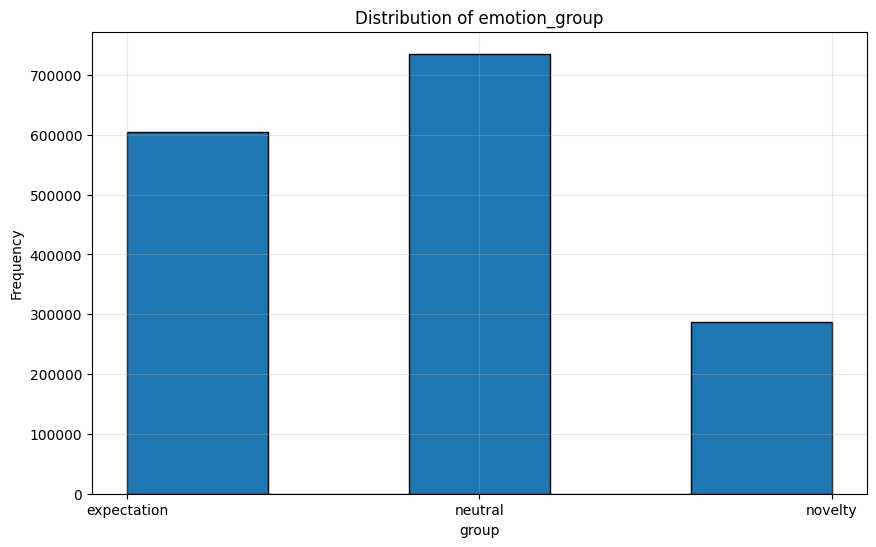

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_comments_sample['emotion_group'].dropna(), bins=5, edgecolor='black')
plt.title('Distribution of emotion_group')
plt.xlabel('group')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
group_counts = df_comments_sample.groupby(['submission_id', 'emotion_group']).size().unstack(fill_value=0)

for grp in ["novelty", "expectation", "neutral"]:
    if grp not in group_counts.columns:
        group_counts[grp] = 0

In [ ]:
def dominant_group_count(row):

    nov, exp, neut = row["novelty"], row["expectation"], row["neutral"]

    if nov == exp and nov >= neut:
        return "neutral"
    if neut > nov and neut > exp:
        return "neutral"
    if nov > exp and nov >= neut:
        return "novelty"
    if exp > nov and exp >= neut:
        return "expectation"
    # If all equal (rare) or empty, call it neutral
    return "neutral"

In [ ]:
dominant_groups = group_counts.apply(dominant_group_count, axis=1)
# Map group: expectation=0, neutral=0.5, novelty=1
group_to_value = {"expectation": 0.0, "neutral": 0.5, "novelty": 1.0}
emotion_feature = dominant_groups.map(group_to_value)

In [ ]:

df_sample['emotion_score'] = df_sample['id'].map(emotion_feature)
df_sample['emotion_score'].fillna(0.5, inplace=True)  # if any missing (no comments or tie), assign neutral 0.5
print("Sample of emotion feature values:", df_sample[['id','emotion_score']].head(5))

Sample of emotion feature values:        id  emotion_score
0  1lvef5            0.0
1  dcx1bq            0.0
2  b7qn6m            0.0
3  3azj61            0.0
4  6klf2u            0.5


<ipython-input-45-3475db43cc3c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sample['emotion_score'].fillna(0.5, inplace=True)  # if any missing (no comments or tie), assign neutral 0.5


In [ ]:
print(df_sample['emotion_score'].value_counts())

emotion_score
0.5    60148
0.0    33374
1.0     6478
Name: count, dtype: int64


In [ ]:
# Save DataFrame to TSV
output_path = os.path.join(output_dir, 'df_sample_100k.tsv')
df_sample.to_csv(output_path, sep='\t', index=False)
print(f"DataFrame saved to {output_path}")

# Verify file existence
print("File exists:", os.path.exists(output_path))

DataFrame saved to /content/gdrive/MyDrive/YX_homework/df_sample_100k.tsv
File exists: True


In [ ]:
output_dir = '/content/news_data'

In [ ]:
import pandas as pd
import os

# Define the path to the TSV file
output_path = os.path.join(output_dir, 'df_sample_100k.tsv')

# Read the TSV file back into a DataFrame
df_sample = pd.read_csv(output_path, sep='\t')

# Optional: Verify the DataFrame
print(f"DataFrame loaded from {output_path}")
print(f"Shape of loaded DataFrame: {df_sample.shape}")

DataFrame loaded from /content/news_data/df_sample_100k.tsv
Shape of loaded DataFrame: (100000, 19)


In [ ]:
df_sample.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score,emotion_score
0,NaN,irs spent to make parody of trumps apprentice,1.378496e+09,washingtontimes.com,True,1lvef5,https://external-preview.redd.it/ShAIXfDYep86x...,NaN,7.0,167,nottheonion,"IRS spent $10,000 to make parody of Trump's 'A...",0.88,1,0,0,irs spent make parody trumps apprentice,-0.100000,0.0
1,MyPilotsRomance,this cloud casting a big shadow,1.570136e+09,i.redd.it,True,dcx1bq,https://preview.redd.it/5udgxv9p0dq31.jpg?widt...,NaN,4.0,32,photoshopbattles,PsBattle: this cloud casting a big shadow,0.85,1,0,0,cloud casting big shadow,0.000000,0.0
2,howtokillyourdreams,my poor positioning and the fact that the sky ...,1.554055e+09,i.redd.it,True,b7qn6m,https://preview.redd.it/0xmqk4xyuhp21.jpg?widt...,NaN,3.0,15,mildlyinteresting,My poor positioning (and the fact that the sky...,0.84,1,0,0,poor positioning fact sky included reason see ...,-0.400000,0.0
3,Nekronicle,poop hot seller at disney world,1.435174e+09,lasvegasnow.com,True,3azj61,https://external-preview.redd.it/K2lUz2pypkqVR...,NaN,2.0,13,nottheonion,Poop: Hot seller at Disney World,0.93,1,0,0,poop hot seller disney world,0.250000,0.0
4,NaN,gov chris christie at the stroke of midnight f...,1.498888e+09,nj.com,True,6klf2u,https://external-preview.redd.it/k3c-gV-l7qMVo...,NaN,1.0,3,usanews,Gov. Chris Christie at the stroke of midnight ...,0.72,1,0,0,gov chris christie stroke midnight friday orde...,-0.075758,0.5


## 6. Prepare Data for Modeling

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X_text = df_sample['title_cleaned'].astype(str).values  # title text
X_sentiment = df_sample['sentiment_score'].values
X_emotion = df_sample['emotion_score'].values
y = df_sample['2_way_label'].values

In [ ]:
# Split into train and test sets
X_text_train, X_text_test, X_sent_train, X_sent_test, X_emot_train, X_emot_test, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_emotion, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_text_train))
print("Testing samples:", len(X_text_test))

Training samples: 80000
Testing samples: 20000


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

X_seq_train = tokenizer.texts_to_sequences(X_text_train)
X_seq_test  = tokenizer.texts_to_sequences(X_text_test)

max_len = max(len(seq) for seq in X_seq_train)
X_seq_train = pad_sequences(X_seq_train, maxlen=max_len, padding='post')
X_seq_test  = pad_sequences(X_seq_test, maxlen=max_len, padding='post')
print("Max title length:", max_len)
print("Shape of padded train sequences:", X_seq_train.shape)

Vocabulary size: 40902
Max title length: 37
Shape of padded train sequences: (80000, 37)


In [ ]:
# !curl -I http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
import numpy as np
# Load GloVe 100d into memory
embeddings_index = {}
with open('/content/news_data/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coeffs
print("Total GloVe vectors loaded:", len(embeddings_index))

Total GloVe vectors loaded: 400000


In [ ]:

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

## 7. Build the Bi-LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Model architecture
title_input = Input(shape=(max_len,), name='title_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_len, trainable=True)(title_input)  # Removed kernel_regularizer
x = Dropout(0.35)(embedding_layer)  # Added dropout after embedding to regularize
x = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.002),
         recurrent_dropout=0.3)(x)  # Unidirectional LSTM
x = Dropout(0.3)(x)
text_repr = Dense(32, activation='relu', kernel_regularizer=l2(0.002))(x)

sent_input = Input(shape=(1,), name='sentiment_input')
sent_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.002))(sent_input)
emot_input = Input(shape=(1,), name='emotion_input')
emot_dense = Dense(16, activation='relu', kernel_regularizer=l2(0.002))(emot_input)

combined = Concatenate()([text_repr, sent_dense, emot_dense])
combined = Dense(24, activation='relu', kernel_regularizer=l2(0.002))(combined)
combined = Dropout(0.3)(combined)
output = Dense(1, activation='sigmoid')(combined)

# Compile model
model = Model(inputs=[title_input, sent_input, emot_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 37, 100)   │  4,090,200 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 37, 100)   │          0 │ embedding_4[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     42,240 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 16)        │         32 │ sentiment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │         32 │ emotion_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64)        │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_21[0][0],   │
│                     │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 24)        │      1,560 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 24)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │         25 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,136,169 (15.78 MB)

 Trainable params: 4,136,169 (15.78 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the Model

In [ ]:
# Prepare inputs for training and testing
X_train_inputs = {
    'title_input': X_seq_train,
    'sentiment_input': X_sent_train,
    'emotion_input': X_emot_train
}
X_test_inputs = {
    'title_input': X_seq_test,
    'sentiment_input': X_sent_test,
    'emotion_input': X_emot_test
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_sent_train = scaler.fit_transform(X_sent_train.reshape(-1, 1))
X_sent_test = scaler.transform(X_sent_test.reshape(-1, 1))
X_emot_train = scaler.fit_transform(X_emot_train.reshape(-1, 1))
X_emot_test = scaler.transform(X_emot_test.reshape(-1, 1))

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print("Train label distribution:", np.bincount(y_train) / len(y_train))
print("Test label distribution:", np.bincount(y_test) / len(y_test))

Train label distribution: [0.5 0.5]
Test label distribution: [0.5 0.5]


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Training
history = model.fit(X_train_inputs, y_train,
                    validation_data=(X_test_inputs, y_test),
                    epochs=20,
                    batch_size=256,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.5735 - auc: 0.6016 - loss: 0.9373 - val_accuracy: 0.7144 - val_auc: 0.7848 - val_loss: 0.6562 - learning_rate: 5.0000e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.7122 - auc: 0.7581 - loss: 0.6552 - val_accuracy: 0.7387 - val_auc: 0.8132 - val_loss: 0.6015 - learning_rate: 5.0000e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.7368 - auc: 0.7938 - loss: 0.6037 - val_accuracy: 0.7448 - val_auc: 0.8241 - val_loss: 0.5752 - learning_rate: 5.0000e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.7546 - auc: 0.8125 - loss: 0.5788 - val_accuracy: 0.7546 - val_auc: 0.8330 - val_loss: 0.5633 - learning_rate: 5.0000e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.7681 - auc: 0.8313 - loss: 0.5593 - val_accuracy: 0.7606 - val_auc: 0.8414 - val_loss: 0.5494 - learning_rate: 5.0000e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 1

## 9. Evaluate the Model

In [ ]:
# Evaluate on test set
loss, accuracy, auc = model.evaluate(X_test_inputs, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# compute AUC
y_pred_prob = model.predict(X_test_inputs)
from sklearn.metrics import roc_auc_score, accuracy_score
auc_manual = roc_auc_score(y_test, y_pred_prob)
acc_manual = accuracy_score(y_test, (y_pred_prob >= 0.5).astype(int))
print(f"Manual Accuracy: {acc_manual:.4f}")
print(f"Manual AUC: {auc_manual:.4f}")


Test Accuracy: 0.7724
Test AUC: 0.8524
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step
Manual Accuracy: 0.7724
Manual AUC: 0.8529


In [ ]:
print("Training loss:", history.history['loss'])
print("Validation loss:", history.history['val_loss'])
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])
print("Training AUC:", history.history['auc'])
print("Validation AUC:", history.history['val_auc'])

Training loss: [0.8164250254631042, 0.63991779088974, 0.5988489389419556, 0.5743260979652405, 0.5553075075149536, 0.5391685962677002, 0.5270640850067139, 0.5164909958839417, 0.5080260038375854, 0.4986109733581543, 0.4882810413837433, 0.4831329584121704]
Validation loss: [0.6561963558197021, 0.6014767289161682, 0.5752488970756531, 0.5632951259613037, 0.549445390701294, 0.544233500957489, 0.5430805683135986, 0.5402918457984924, 0.5406346917152405, 0.538917064666748, 0.539635181427002, 0.5396658778190613]
Training accuracy: [0.6346374750137329, 0.7156749963760376, 0.7385125160217285, 0.7559750080108643, 0.7707499861717224, 0.7814375162124634, 0.7935125231742859, 0.8006374835968018, 0.8089625239372253, 0.8157250285148621, 0.8226374983787537, 0.8278499841690063]
Validation accuracy: [0.7143999934196472, 0.7387499809265137, 0.7447999715805054, 0.7545999884605408, 0.7605999708175659, 0.7659000158309937, 0.7675999999046326, 0.7696999907493591, 0.769599974155426, 0.7724499702453613, 0.771899998

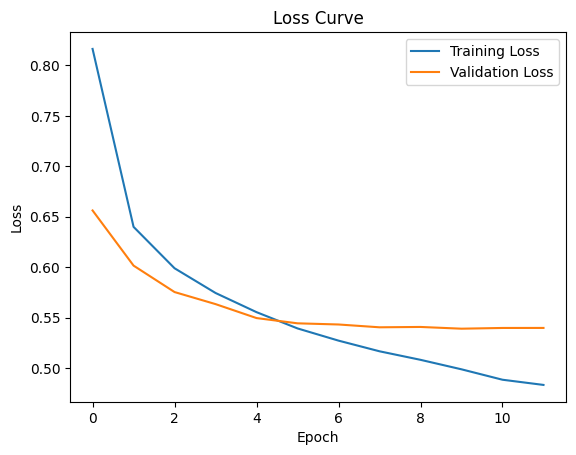

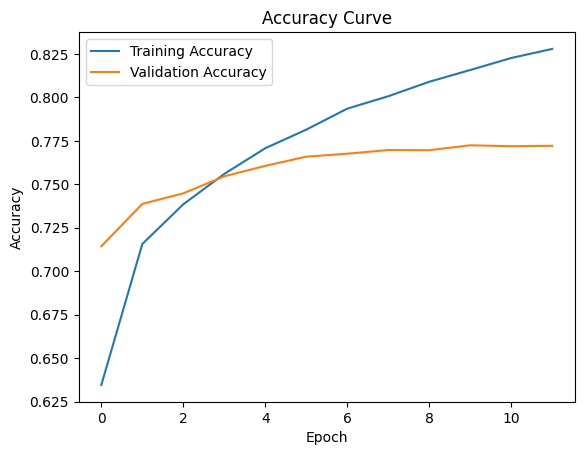

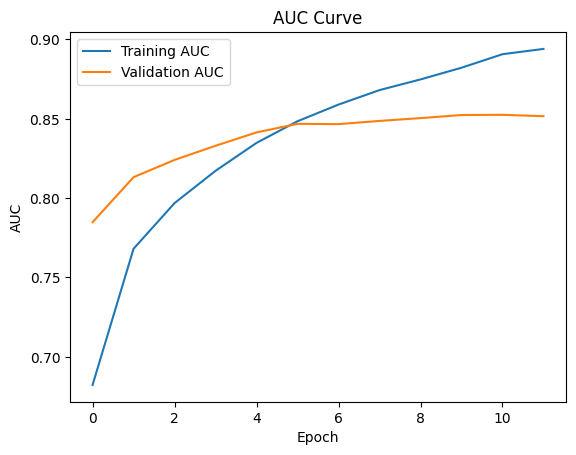

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [ ]:
# Define the target directory
output_dir = '/content/gdrive/MyDrive/fakenews_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

output_path = os.path.join(output_dir, 'com_model_100k.h5')
model.save(output_path)

weight_path = os.path.join(output_dir, 'com1_model_100k.weights.h5')
model.save_weights(weight_path)

print(f"model saved to {output_path}")

print("File exists:", os.path.exists(output_path))

print(f"model saved to {weight_path}")

print("File exists:", os.path.exists(weight_path))

Created directory: /content/gdrive/MyDrive/fakenews_data
model saved to /content/gdrive/MyDrive/fakenews_data/com_model_100k.h5
File exists: True
model saved to /content/gdrive/MyDrive/fakenews_data/com1_model_100k.weights.h5
File exists: True


In [ ]:
loaded_model = tf.keras.models.load_model(output_path)
loaded_model.evaluate(X_test_inputs, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7749 - auc: 0.8531 - loss: 0.5373


[0.5389165282249451, 0.7724499702453613, 0.8523707985877991]

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler



In [ ]:
model

<Functional name=functional_4, built=True>

In [ ]:

def preprocess_inputs(df, tokenizer, scaler_sent, scaler_emot, max_len):

    X_text = df['title_cleaned'].astype(str).values
    X_sentiment = df['sentiment_score'].values
    X_emotion = df['emotion_score'].values


    X_seq = tokenizer.texts_to_sequences(X_text)
    X_seq = pad_sequences(X_seq, maxlen=max_len, padding='post')


    X_sentiment = scaler_sent.transform(X_sentiment.reshape(-1, 1))
    X_emotion = scaler_emot.transform(X_emotion.reshape(-1, 1))

    X_inputs = {
        'title_input': X_seq,
        'sentiment_input': X_sentiment,
        'emotion_input': X_emotion
    }
    return X_inputs

In [ ]:

scaler_sent = MinMaxScaler().fit(X_sentiment.reshape(-1, 1))
scaler_emot = MinMaxScaler().fit(X_emotion.reshape(-1, 1))
max_len = max(len(seq) for seq in tokenizer.texts_to_sequences(df_sample['title_cleaned'].astype(str)))


X_inputs = preprocess_inputs(df_sample, tokenizer, scaler_sent, scaler_emot, max_len)


probit = model.predict(X_inputs)
predictions = (probit >= 0.5).astype(int)


df_sample['probit'] = probit.flatten()
df_sample['predicted_label'] = predictions.flatten()


if '2_way_label' in df_sample.columns:
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(df_sample['2_way_label'], df_sample['predicted_label'])
    print(f"Overall accuracy: {accuracy:.4f}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 79s 25ms/step
Overall accuracy: 0.8327


In [ ]:
df_sample.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,...,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score,emotion_score,probit,predicted_label
0,NaN,irs spent to make parody of trumps apprentice,1.378496e+09,washingtontimes.com,True,1lvef5,https://external-preview.redd.it/ShAIXfDYep86x...,NaN,7.0,167,...,"IRS spent $10,000 to make parody of Trump's 'A...",0.88,1,0,0,irs spent make parody trumps apprentice,-0.100000,0.0,0.210335,0
1,MyPilotsRomance,this cloud casting a big shadow,1.570136e+09,i.redd.it,True,dcx1bq,https://preview.redd.it/5udgxv9p0dq31.jpg?widt...,NaN,4.0,32,...,PsBattle: this cloud casting a big shadow,0.85,1,0,0,cloud casting big shadow,0.000000,0.0,0.824123,1
2,howtokillyourdreams,my poor positioning and the fact that the sky ...,1.554055e+09,i.redd.it,True,b7qn6m,https://preview.redd.it/0xmqk4xyuhp21.jpg?widt...,NaN,3.0,15,...,My poor positioning (and the fact that the sky...,0.84,1,0,0,poor positioning fact sky included reason see ...,-0.400000,0.0,0.081744,0
3,Nekronicle,poop hot seller at disney world,1.435174e+09,lasvegasnow.com,True,3azj61,https://external-preview.redd.it/K2lUz2pypkqVR...,NaN,2.0,13,...,Poop: Hot seller at Disney World,0.93,1,0,0,poop hot seller disney world,0.250000,0.0,0.572254,1
4,NaN,gov chris christie at the stroke of midnight f...,1.498888e+09,nj.com,True,6klf2u,https://external-preview.redd.it/k3c-gV-l7qMVo...,NaN,1.0,3,...,Gov. Chris Christie at the stroke of midnight ...,0.72,1,0,0,gov chris christie stroke midnight friday orde...,-0.075758,0.5,0.859696,1


In [ ]:

print(df_sample[['title_cleaned', 'sentiment_score', 'emotion_score', 'probit', 'predicted_label']].head())

                                       title_cleaned  sentiment_score  \
0            irs spent make parody trumps apprentice        -0.100000   
1                           cloud casting big shadow         0.000000   
2  poor positioning fact sky included reason see ...        -0.400000   
3                       poop hot seller disney world         0.250000   
4  gov chris christie stroke midnight friday orde...        -0.075758   

   emotion_score    probit  predicted_label  
0            0.0  0.210335                0  
1            0.0  0.824123                1  
2            0.0  0.081744                0  
3            0.0  0.572254                1  
4            0.5  0.859696                1  


Classification Metrics:
Accuracy: 0.8327
Precision: 0.7962
Recall: 0.8943
F1 Score: 0.8424
ROC-AUC: 0.9081


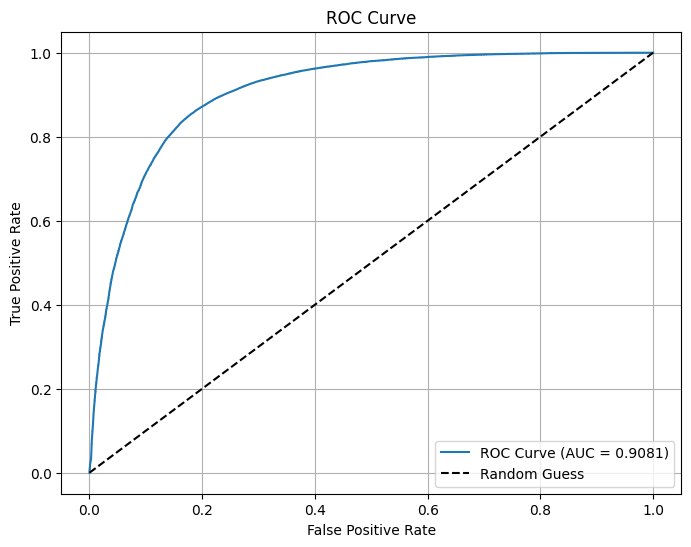

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


required_columns = ['2_way_label', 'probit', 'predicted_label']
if not all(col in df_sample.columns for col in required_columns):
    raise ValueError("df_sample is missing one or more required columns: '2_way_label', 'probit', 'predicted_label'")

y_true = df_sample['2_way_label'].values
y_pred = df_sample['predicted_label'].values
y_prob = df_sample['probit'].values


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


roc_auc = roc_auc_score(y_true, y_prob)


print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:

df_sample.to_csv('/content/gdrive/MyDrive/fakenews_data/output_comments_model.csv', index=False)
print("Predictions saved to 'df_sample_with_predictions.csv'")

Predictions saved to 'df_sample_with_predictions.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os


output_file = '/content/gdrive/MyDrive/fakenews_data/output_comments_model.csv'
output_dir = '/content/gdrive/MyDrive/fakenews_data'


if os.path.exists(output_file):
    df_loaded = pd.read_csv(output_file)
    print(f"Successfully loaded file: {output_file}")
    print(f"Number of rows: {len(df_loaded)}")
else:
    raise FileNotFoundError(f"File not found at {output_file}")


print("\n=== Data Validation ===")

required_columns = ['2_way_label', 'probit', 'predicted_label']
missing_columns = [col for col in required_columns if col not in df_loaded.columns]
if missing_columns:
    print(f"Warning: Missing columns: {missing_columns}")
else:
    print("All required columns present:", required_columns)


probit_min, probit_max = df_loaded['probit'].min(), df_loaded['probit'].max()
print(f"Probit range: [{probit_min:.4f}, {probit_max:.4f}]")
if not (0 <= probit_min <= probit_max <= 1):
    print("Warning: Probit values are outside [0, 1] range!")


unique_labels = df_loaded['predicted_label'].unique()
print(f"Predicted labels: {unique_labels}")
if not set(unique_labels).issubset({0, 1}):
    print("Warning: Predicted labels contain values other than 0 or 1!")


print("\nClass distribution of true labels:")
print(df_loaded['2_way_label'].value_counts(normalize=True))



Successfully loaded file: /content/gdrive/MyDrive/fakenews_data/output_comments_model.csv
Number of rows: 100000

=== Data Validation ===
All required columns present: ['2_way_label', 'probit', 'predicted_label']
Probit range: [0.0541, 0.8794]
Predicted labels: [0 1]

Class distribution of true labels:
2_way_label
1    0.5
0    0.5
Name: proportion, dtype: float64



Comparing with original df_sample:
Original row count: 100000
Loaded row count: 100000
Row counts match!
Column '2_way_label' matches perfectly
Column 'predicted_label' matches perfectly

=== Classification Metrics ===
Accuracy: 0.8327
Precision: 0.7962
Recall: 0.8943
F1 Score: 0.8424
ROC-AUC: 0.9081


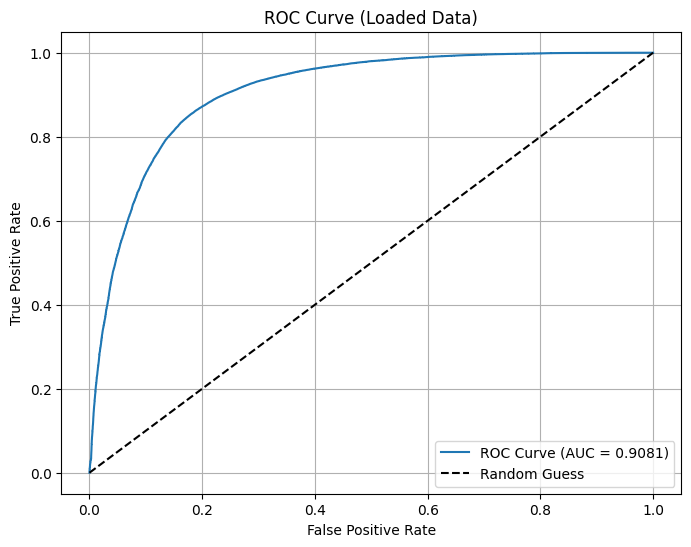

In [ ]:

if 'df_sample' in globals():
    print("\nComparing with original df_sample:")
    print(f"Original row count: {len(df_sample)}")
    print(f"Loaded row count: {len(df_loaded)}")
    if len(df_sample) == len(df_loaded):
        print("Row counts match!")

        for col in required_columns:
            if (df_sample[col] == df_loaded[col]).all():
                print(f"Column '{col}' matches perfectly")
            else:
                print(f"Warning: Column '{col}' has differences")
    else:
        print("Warning: Row counts do not match!")


print("\n=== Classification Metrics ===")
y_true = df_loaded['2_way_label'].values
y_pred = df_loaded['predicted_label'].values
y_prob = df_loaded['probit'].values


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_prob)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Loaded Data)')
plt.legend(loc='lower right')
plt.grid(True)

In [ ]:
df_loaded

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,...,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score,emotion_score,probit,predicted_label
0,NaN,irs spent to make parody of trumps apprentice,1.378496e+09,washingtontimes.com,True,1lvef5,https://external-preview.redd.it/ShAIXfDYep86x...,NaN,7.0,167,...,"IRS spent $10,000 to make parody of Trump's 'A...",0.88,1,0,0,irs spent make parody trumps apprentice,-0.100000,0.0,0.210335,0
1,MyPilotsRomance,this cloud casting a big shadow,1.570136e+09,i.redd.it,True,dcx1bq,https://preview.redd.it/5udgxv9p0dq31.jpg?widt...,NaN,4.0,32,...,PsBattle: this cloud casting a big shadow,0.85,1,0,0,cloud casting big shadow,0.000000,0.0,0.824123,1
2,howtokillyourdreams,my poor positioning and the fact that the sky ...,1.554055e+09,i.redd.it,True,b7qn6m,https://preview.redd.it/0xmqk4xyuhp21.jpg?widt...,NaN,3.0,15,...,My poor positioning (and the fact that the sky...,0.84,1,0,0,poor positioning fact sky included reason see ...,-0.400000,0.0,0.081744,0
3,Nekronicle,poop hot seller at disney world,1.435174e+09,lasvegasnow.com,True,3azj61,https://external-preview.redd.it/K2lUz2pypkqVR...,NaN,2.0,13,...,Poop: Hot seller at Disney World,0.93,1,0,0,poop hot seller disney world,0.250000,0.0,0.572254,1
4,NaN,gov chris christie at the stroke of midnight f...,1.498888e+09,nj.com,True,6klf2u,https://external-preview.redd.it/k3c-gV-l7qMVo...,NaN,1.0,3,...,Gov. Chris Christie at the stroke of midnight ...,0.72,1,0,0,gov chris christie stroke midnight friday orde...,-0.075758,0.5,0.859696,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,all-top-today_SS,the strength of a fire hydrant and a fire hydr...,1.551287e+09,i.redd.it,True,avfmop,https://preview.redd.it/lquqhf3j8yi21.jpg?widt...,NaN,18.0,30,...,The strength of a fire hydrant and a fire hydr...,0.85,0,2,3,strength fire hydrant fire hydrant km run ever...,-0.071429,0.0,0.330782,0
99996,FloridaMan_SS,people wind up in the face with ramen noodles,1.507791e+09,dailymail.co.uk,True,75vbcc,https://external-preview.redd.it/NVuXPi8HNdrE9...,NaN,23.0,17,...,3 people wind up in the face with Ramen noodles,0.99,0,2,3,people wind face ramen noodles,0.000000,0.0,0.372933,0
99997,BearcatChemist,redheaded girl in attack mode,1.418050e+09,i.imgur.com,True,2ondsg,https://external-preview.redd.it/H3UqCq9VHC3jh...,NaN,642.0,6252,...,PsBattle: Red-headed girl in attack mode.,0.87,1,0,0,redheaded girl attack mode,0.000000,0.5,0.828237,1
99998,BleuTomateio,glitter coming down from the new years party i...,1.552945e+09,i.imgur.com,True,b2og7i,https://external-preview.redd.it/b2xLhrJrl6Kbz...,NaN,0.0,19,...,Glitter coming down from the New Years party i...,0.84,0,2,2,glitter coming new years party heaven,0.136364,0.5,0.221480,0
